Carga de las librerías

In [2]:
import telebot
from telebot.types import ReplyKeyboardMarkup,ReplyKeyboardRemove
from config import TOKEN
from random import randint
import random
import pandas as pd
import dash as dss
import plotly.express as px
from telebot.types import InputFile
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import re

In [5]:
pattern = r'^(\S+) (\S+) (\S+) \[(.*?)\] "(\S+) (\S+) (\S+)" (\d+) (\d+) "([^"]+)" "([^"]+)"'

# Lista para almacenar los resultados
data = []

# Leer el archivo de texto línea por línea
with open('../Datos/Originales/apache-logs.txt', 'r') as file:
    for log_line in file:
        matches = re.match(pattern, log_line)
        if matches:
            client_ip, ident, auth, timestamp, method, request, hhtp_version, status_code, bytes_sent, referrer, user_agent = matches.groups()
            data.append([client_ip, ident, auth, timestamp, method, request, hhtp_version, status_code, bytes_sent, referrer, user_agent])
        else:
            print("No match found for line:", log_line)

# Crear DataFrame
df_apache = pd.DataFrame(data, columns=['Client IP', 'Ident', 'Auth', 'Timestamp', 'Method', 'Request', 'HTTP Version', 'Status Code', 'Bytes Sent', 'Referrer', 'User Agent'])

# Mostrar el DataFrame
df_apache

No match found for line: "192.168.4.164 - - [22/Dec/2023:15:19:14 +0300] "GET /DVWA/ HTTP/1.1" 200 1964 "() { :;}; echo \"NS:\" $(/bin/sh -c \"expr 268409241 - 2\")" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""

No match found for line: "192.168.4.164 - - [22/Dec/2023:15:19:15 +0300] "GET /DVWA/ HTTP/1.1" 200 1964 "'\"@--></style></scRipt><scRipt>netsparker(0x000008)</scRipt>" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""

No match found for line: "192.168.4.164 - - [22/Dec/2023:15:19:15 +0300] "GET /DVWA/ HTTP/1.1" 200 1964 "'\"@--></style></scRipt><scRipt>netsparker(0x000009)</scRipt>" "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2272.16 Safari/537.36""

No match found for line: "192.168.4.164 - - [22/Dec/2023:15:19:15 +0300] "GET /DVWA/ HTTP/1.1" 200 1964 "'\"--></style></scRipt><scRipt>netsparker(0x000006)</s

,Client IP,Ident,Auth,Timestamp,Method,Request,HTTP Version,Status Code,Bytes Sent,Referrer,User Agent
0,"""192.168.4.164",-,-,22/Dec/2023:15:19:05 +0300,GET,/DVWA/,HTTP/1.1,200,2020,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
1,"""192.168.4.164",-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/,HTTP/1.1,200,263,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
2,"""192.168.4.164",-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
3,"""192.168.4.164",-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.git/config,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
4,"""192.168.4.164",-,-,22/Dec/2023:15:19:06 +0300,HEAD,/DVWA/.svn/all-wcprops,HTTP/1.1,404,139,-,Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKi...
...,...,...,...,...,...,...,...,...,...,...,...
13617,"""192.168.4.25",-,-,22/Dec/2022:16:22:11 +0300,POST,/index.php/component/search/,HTTP/1.1,303,376,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
13618,"""192.168.4.25",-,-,22/Dec/2022:16:33:44 +0300,POST,/index.php/component/search/,HTTP/1.1,303,417,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
13619,"""192.168.4.25",-,-,22/Dec/2022:16:23:07 +0300,POST,/index.php/component/search/,HTTP/1.1,303,393,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...
13620,"""192.168.4.25",-,-,22/Dec/2022:16:32:54 +0300,POST,/index.php/component/search/,HTTP/1.1,200,3054,http://192.168.4.161/DVWA,Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKi...


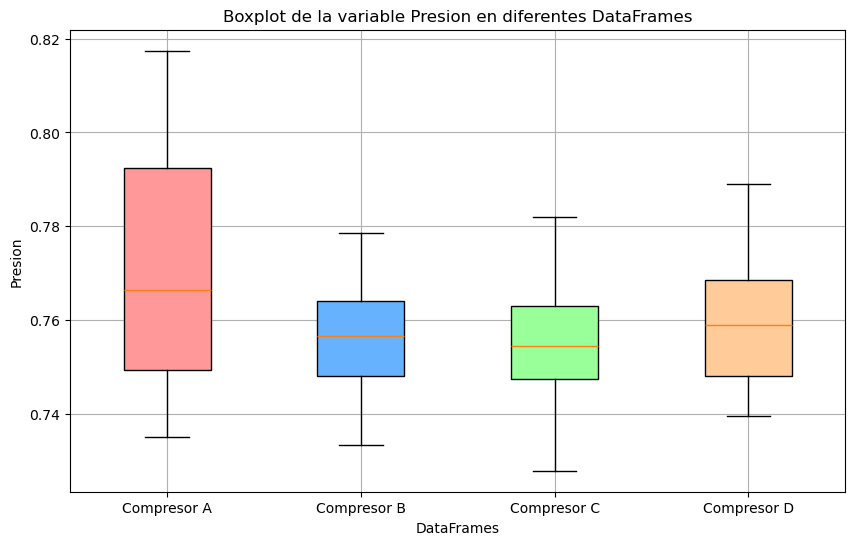

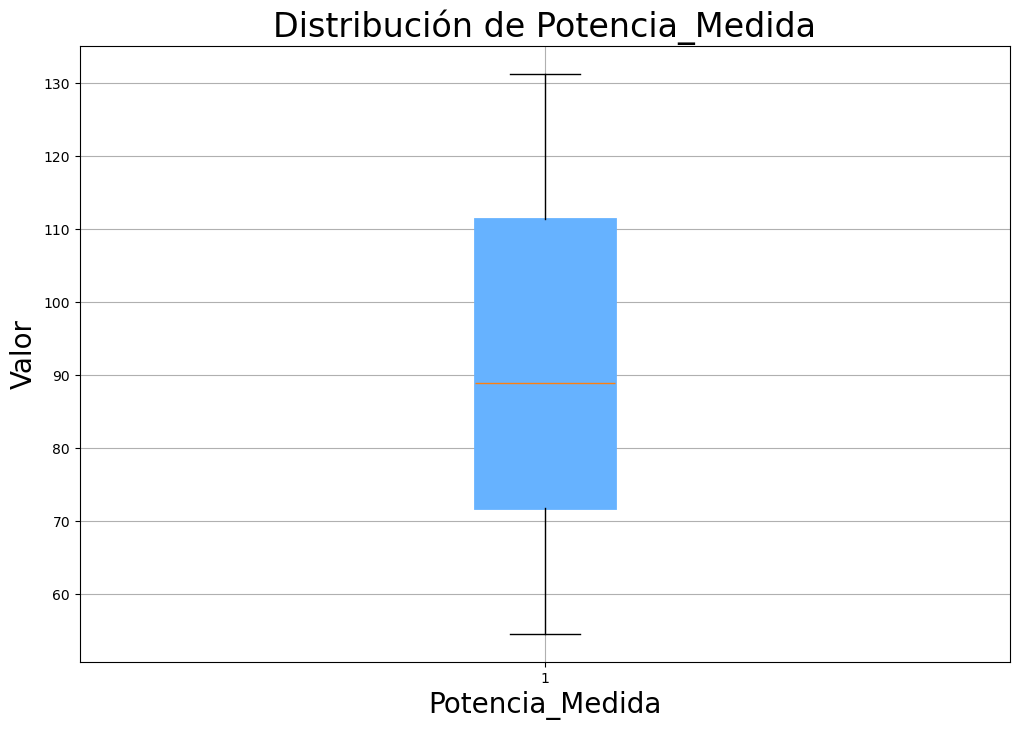

In [9]:
# Inicializar el bot
bot = telebot.TeleBot(TOKEN)


####################################################### Comando (Consultas) ##############################################################################

# params = dict()

# @bot.message_handler(commands=["count"])
# def consultar(message):
#     if len(message.text.split(" ")) < 2:
#         bot.reply_to(message, "Por favor, proporcione el nombre del índice.")
#         return
    
#     index_name = message.text.split(" ")[1]
#     try:
#         count = client.count(index=index_name)['count']
#         bot.reply_to(message, f"El índice {index_name} contiene {count} documentos.")
#     except ValueError as e:
#         bot.reply_to(message, f"Error al obtener la cantidad de documentos del índice {index_name}: {e}")
#         # poner que si no encuentra el indice o hay algun error algun mensaje de respuesta


####################################################### Comando (Grafico) ##############################################################################


@bot.message_handler(commands=["grafico", "gráfico"])


def seleccion(message):
    documento = message.text.split()[-1]
    if documento not in ["comp_a", "comp_b", "comp_c", "comp_d", "compresores", "apache", "firewall"]:
        error = bot.send_message(message.chat.id, "Has seleccionado un documento no disponible. Por favor, selecciona uno de los siguientes documentos: comp_a, comp_b, comp_c, comp_d")
        bot.register_next_step_handler(error, seleccion)
    else:
      if documento == "comp_a":
            global df
            df = pd.read_csv("../Datos/Originales/Comp_A.csv")
            variable_compresor(message)
      elif documento == "comp_b":
            df = pd.read_csv("../Datos/Originales/Comp_B.csv")
            variable_compresor(message)
      elif documento == "comp_c":
            df = pd.read_csv("../Datos/Originales/Comp_C.csv")
            variable_compresor(message)
      elif documento == "comp_d":
            df = pd.read_csv("../Datos/Originales/Comp_D.csv")
            variable_compresor(message)
      elif documento == "compresores":
          global dfa, dfb, dfc, dfd
          dfa = pd.read_csv("../Datos/Originales/Comp_A.csv")
          dfb = pd.read_csv("../Datos/Originales/Comp_B.csv")
          dfc = pd.read_csv("../Datos/Originales/Comp_C.csv")
          dfd = pd.read_csv("../Datos/Originales/Comp_D.csv")
          variable_compresores(message)

      elif documento == "firewall":
          global df_firewall
          df_firewall = pd.read_csv("../Datos/Originales/log2.csv")
          variable_firewall(message)


############################################################# FIREWALL #######################################################################################

def variable_firewall(message):
    markup = ReplyKeyboardMarkup(one_time_keyboard=True, resize_keyboard=True, input_field_placeholder="Selecciona una variable para realizar el gráfico de distribución")
    markup.add("Bytes", "Bytes Sent", "Bytes Received", "Packets", "Elapsed Time (sec)")
    msg = bot.send_message(message.chat.id, "Selecciona una variable para realizar el gráfico", reply_markup=markup)
    bot.register_next_step_handler(msg, validar_variable_firewall)

def validar_variable_firewall(message):
    global variable
    variable = message.text
    opciones_validas = ["Bytes", "Bytes Sent", "Bytes Received", "Packets", "Elapsed Time (sec)"]
    
    if variable in opciones_validas:
        seleccionar_tipo_grafico(message)
    else:
        error_msg = "Parece que no has seleccionado una variable disponible. Prueba a seleccionar una de las siguientes opciones: Bytes, Bytes Sent, Bytes Received, Packets o Elapsed Time (sec)"
        bot.send_message(message.chat.id, error_msg)
        variable_firewall(message)

def seleccionar_tipo_grafico(message):
    markup = ReplyKeyboardMarkup(one_time_keyboard=True, resize_keyboard=True, input_field_placeholder="Selecciona un tipo de gráfico")
    markup.add("Boxplot", "Histograma")
    msg = bot.send_message(message.chat.id, "Selecciona un tipo de gráfico", reply_markup=markup)
    bot.register_next_step_handler(msg, graficado_firewall)

def graficado_firewall(message):
    grafico = message.text
    if grafico not in ["Boxplot", "Histograma"]:
        error = bot.send_message(message.chat.id, "Has seleccionado un gráfico no disponible. Por favor, selecciona uno de los siguientes: Boxplot o Histograma")
        bot.register_next_step_handler(error, seleccionar_tipo_grafico)
    else:
        if grafico == "Boxplot":
            fig, ax = plt.subplots(figsize=(12, 8))
            bp = ax.boxplot(df_firewall[variable], patch_artist=True)

            # Cambiar el color de la caja a un tono de azul más suave
            for box in bp['boxes']:
                box.set(color='#66B2FF', linewidth=2)

            # Cambiar el color y el estilo de los markers
            for flier in bp['fliers']:
                flier.set(marker='^', markerfacecolor='#66B2FF', alpha=0.5)

            ax.set_xlabel(f"{variable}", fontdict={"fontsize": 20})
            ax.set_ylabel('Valor', fontdict={"fontsize": 20})
            ax.set_title(f"Distribución de {variable}", fontdict={"fontsize": 24})
            ax.grid(True)
            fig.savefig("temp.png")
            binary = InputFile(open("temp.png", "rb"))
            bot.send_photo(message.chat.id, photo=binary)

        elif grafico == "Histograma":
            fig = plt.figure(figsize=(16, 16))
            ax = fig.add_subplot()
            ax.hist(df_firewall[variable])
            ax.set_xlabel(f"{variable}", fontdict={"fontsize": 30})
            ax.set_ylabel('Frecuencia', fontdict={"fontsize": 30})
            ax.set_title(f"Distribución de {variable}", fontdict={"fontsize": 40})
            fig.savefig("temp.png")
            binary = InputFile(open("temp.png", "rb"))
            bot.send_photo(message.chat.id, photo=binary)



############################################################# Compresores #######################################################################################


def variable_compresores(message):
    markup = ReplyKeyboardMarkup(one_time_keyboard=True, resize_keyboard=True, input_field_placeholder="Selecciona una variable para realizar el gráfico de distribución")
    markup.add("Presion", "Temperatura", "Frecuencia", "Potencia_Medida")
    msg = bot.send_message(message.chat.id, "Selecciona una variable para realizar el gráfico", reply_markup=markup)
    bot.register_next_step_handler(msg, validar_variable_compresores)


def validar_variable_compresores(message):
    global variable
    variable = message.text
    opciones_validas = ["Presion", "Temperatura", "Frecuencia", "Potencia_Medida"]
    
    if variable in opciones_validas:
        graficado_multiple(message)
    else:
        error_msg = "Parece que no has seleccionado una variable disponible. Prueba a seleccionar una de las siguientes opciones: Presion, Temperatura, Frecuencia o Potencia_Medida"
        bot.send_message(message.chat.id, error_msg)
        variable_compresores(message)



def graficado_multiple(message):
        data_frames = [dfa, dfb, dfc, dfd]

        # Crear una lista con los datos de la variable de interés de cada DataFrame
        data = [df[variable] for df in data_frames]
        
        colors = ['#FF9999', '#66B2FF', '#99FF99', '#FFCC99']

        # Crear el boxplot
        plt.figure(figsize=(10, 6))
        bp = plt.boxplot(data, labels=['Compresor A', 'Compresor B', 'Compresor C', 'Compresor D'], patch_artist=True)

        # Asignar un color diferente a cada caja
        for box, color in zip(bp['boxes'], colors):
            box.set_facecolor(color)

        # Cambiar el estilo y el color de los markers a los mismos colores de las cajas
        for flier, color in zip(bp['fliers'], colors):
            flier.set(marker='o', markerfacecolor=color, alpha=0.5)

        plt.xlabel('DataFrames')
        plt.ylabel(variable)
        plt.title('Boxplot de la variable ' + variable + ' en diferentes DataFrames')
        plt.grid(True)
        plt.savefig("temp.png")
        binary = InputFile(open("temp.png", "rb"))
        bot.send_photo(message.chat.id, photo=binary)


############################################################# Compresores (individual) #######################################################################################


def variable_compresor(message):
    markup = ReplyKeyboardMarkup(one_time_keyboard=True, resize_keyboard=True, input_field_placeholder="Selecciona una variable para realizar el gráfico de distribución")
    markup.add("Presion", "Temperatura", "Frecuencia", "Potencia_Medida")
    msg = bot.send_message(message.chat.id, "Selecciona una variable para realizar el gráfico", reply_markup=markup)
    bot.register_next_step_handler(msg, validar_variable_compresor)

def validar_variable_compresor(message):
    global variable
    variable = message.text
    opciones_validas = ["Presion", "Temperatura", "Frecuencia", "Potencia_Medida"]
    
    if variable in opciones_validas:
        seleccionar_tipo_grafico_compresor(message)
    else:
        error_msg = "Parece que no has seleccionado una variable disponible. Prueba a seleccionar una de las siguientes opciones: Presion, Temperatura, Frecuencia o Potencia_Medida"
        bot.send_message(message.chat.id, error_msg)
        variable_compresor(message)

def seleccionar_tipo_grafico_compresor(message):
    markup = ReplyKeyboardMarkup(one_time_keyboard=True, resize_keyboard=True, input_field_placeholder="Selecciona un tipo de gráfico")
    markup.add("Boxplot", "Histograma")
    msg = bot.send_message(message.chat.id, "Selecciona un tipo de gráfico", reply_markup=markup)
    bot.register_next_step_handler(msg, graficado_compresor)

def graficado_compresor(message):
    grafico = message.text
    if grafico not in ["Boxplot", "Histograma"]:
        error = bot.send_message(message.chat.id, "Has seleccionado un gráfico no disponible. Por favor, selecciona uno de los siguientes: Boxplot o Histograma")
        bot.register_next_step_handler(error, seleccionar_tipo_grafico_compresor)
    else:
        if grafico == "Boxplot":
            fig, ax = plt.subplots(figsize=(12, 8))
            bp = ax.boxplot(df[variable], patch_artist=True)

            # Cambiar el color de la caja a un tono de azul más suave
            for box in bp['boxes']:
                box.set(color='#66B2FF', linewidth=2)

            # Cambiar el color y el estilo de los markers
            for flier in bp['fliers']:
                flier.set(marker='^', markerfacecolor='#66B2FF', alpha=0.5)

            ax.set_xlabel(f"{variable}", fontdict={"fontsize": 20})
            ax.set_ylabel('Valor', fontdict={"fontsize": 20})
            ax.set_title(f"Distribución de {variable}", fontdict={"fontsize": 24})
            ax.grid(True)
            fig.savefig("temp.png")
            binary = InputFile(open("temp.png", "rb"))
            bot.send_photo(message.chat.id, photo=binary)

        elif grafico == "Histograma":
            fig = plt.figure(figsize=(16, 16))
            ax = fig.add_subplot()
            ax.hist(df[variable])
            ax.set_xlabel(f"{variable}", fontdict={"fontsize": 30})
            ax.set_ylabel('Frecuencia', fontdict={"fontsize": 30})
            ax.set_title(f"Distribución de {variable}", fontdict={"fontsize": 40})
            fig.savefig("temp.png")
            binary = InputFile(open("temp.png", "rb"))
            bot.send_photo(message.chat.id, photo=binary)



# Ejecutar el bot
bot.polling()  # Descomenta esto para que el bot empiece a escuchar